In [1]:
import ee
print(ee.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

0.1.229


In [2]:
ee.Authenticate()

Enter verification code: 4/2gFDSr8nHteVOlmtS55fXFVuF53cv0FyB07WGm0Flo2V3xYthnnlJTk

Successfully saved authorization token.


In [3]:
ee.Initialize()

# Sample Sentinel-2 imagery from France as TFRecords

## Sample boxes

In [4]:
lsib = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

france = lsib.filterMetadata('country_na', 'equals', 'France')

In [80]:
npoints = 100
samples = ee.FeatureCollection.randomPoints(region=france, points=npoints, seed=1)

def buffer_point(x):
    return x.buffer(distance=1120, maxError=1)
def bound_geometry(x):
    return x.bounds()

samples_circles = samples.map(buffer_point)
samples_squares = samples_circles.map(bound_geometry)

## Get Sentinel-2 image for each box

In [52]:
def maskS2clouds(image):
    qa = image.select('QA60')
    
    # Bits 10 and 11 are clouds and cirrus, respectively
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    # Both flags should be set to zero, indicating clear conditions
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    return image.updateMask(mask)

In [53]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
start_date = '2017-04-01'
end_date = '2017-06-30'
apr_jun_s2 = s2.filterBounds(france).filterDate(start_date, end_date)
apr_jun_s2 = apr_jun_s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).map(maskS2clouds)
s2_median = apr_jun_s2.median()

### Janky way: clip each image and export separately

In [54]:
def clip_to_box(x):
    return s2_median.clip(x.geometry())

s2_tiles = samples_squares.map(clip_to_box)

In [71]:
tile_list = s2_tiles.toList(npoints)

for i in range(10):
    img = ee.Image(tile_list.get(i))
    img = img.toUint16()
    fname = 'sentinel2_france_2017_apr-jun_median_seed1_tile{}'.format(str(i).zfill(5))
    print(fname)
    
    task = ee.batch.Export.image.toCloudStorage(image=img,
                                                description='s2_france_tile_{}'.format(i), 
                                                bucket='field_segm_bucket',
                                                fileNamePrefix='EarthEngine/'+fname,
                                                scale=10,
                                                crs='EPSG:4326')
    task.start()

sentinel2_france_2017_apr-jun_median_seed1_tile00000
sentinel2_france_2017_apr-jun_median_seed1_tile00001
sentinel2_france_2017_apr-jun_median_seed1_tile00002
sentinel2_france_2017_apr-jun_median_seed1_tile00003
sentinel2_france_2017_apr-jun_median_seed1_tile00004
sentinel2_france_2017_apr-jun_median_seed1_tile00005
sentinel2_france_2017_apr-jun_median_seed1_tile00006
sentinel2_france_2017_apr-jun_median_seed1_tile00007
sentinel2_france_2017_apr-jun_median_seed1_tile00008
sentinel2_france_2017_apr-jun_median_seed1_tile00009


### Visualize exported images

In [31]:
import imageio

In [38]:
im.shape

(324, 323, 21)

In [72]:
for i in range(10):
    im = imageio.imread('../mount/EarthEngine/sentinel2_france_2017_apr-jun_median_seed1_tile0000{}.tif'.format(i))
    print(im.shape)

(225, 322, 21)
(225, 311, 21)
(225, 330, 21)
(225, 304, 21)
(225, 336, 21)
(226, 312, 21)
(226, 330, 21)
(225, 311, 21)
(225, 339, 21)
(226, 334, 21)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


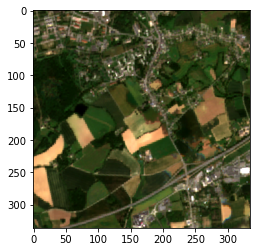

In [49]:
plt.imshow(im[:,:,[3,2,1]] / 2500.)
plt.show()

### Export in aggregate using sampleRectangle and then TFRecord

In [ ]:
# cause TBD. posted on GEE developers asking about it
# solved: a projection issue as described by Chris Brown

test_image = ee.Image("COPERNICUS/S2_SR/20170406T105021_20170406T105317_T31UDR")
CRS = test_image.select('B2').projection()
s2_median = s2_median.reproject(crs=CRS, scale=10).select(['B4', 'B3', 'B2']) # internal error

In [81]:
def get_s2_image(box):
    return s2_median.sampleRectangle(region=box.geometry(), defaultValue=-9)

tiles = samples_squares.map(get_s2_image)

task = ee.batch.Export.table.toCloudStorage(collection=tiles,
                                            description='sentinel2_france_2017_apr-jun_median_n1000_seed1',
                                            bucket='field_segm_bucket', 
                                            fileNamePrefix='EarthEngine/sentinel2_france_2017_apr-jun_median_n1000_seed1', 
                                            fileFormat='TFRecord')

task.start()

In [79]:
print(tiles.first().getInfo())

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[5.7868763727440555, 45.94915402118367], [5.815870224707636, 45.94915402118367], [5.815870224707636, 45.969308106217106], [5.7868763727440555, 45.969308106217106], [5.7868763727440555, 45.94915402118367]]]}, 'id': '0', 'properties': {'B2': [[247, 198.5, 192, 184, 175.5, 211, 243, 356, 248, 241, 225, 223, 383, 531, 513.5, 353.5, 313, 351, 287, 220, 170.5, 154, 160.5, 156, 157.5, 180, 176.5, 191, 213.5, 209.5, 199, 209.5, 191.5, 193.5, 190.5, 207, 222.5, 221.5, 208, 162.5, 238, 392, 371.5, 216, 238, 270, 248, 215.5, 201.5, 218.5, 314.5, 427, 352, 315.5, 303.5, 268.5, 250, 247, 259, 296.5, 321, 293.5, 259.5, 233.5, 249.5, 222, 219.5, 215.5, 170.5, 182.5, 256, 257.5, 241, 228.5, 240, 226.5, 217, 213.5, 228, 282.5, 273, 192.5, 225.5, 215, 218, 229, 218, 218, 198, 232, 234.5, 226, 215.5, 204.5, 236, 232, 210, 201, 225.5, 208.5, 226.5, 206.5, 195.5, 216.5, 222.5, 234.5, 247, 251.5, 269, 239, 251, 298, 290.

In [24]:
square1 = ee.Feature(ee.Geometry.Rectangle([1.871076922665904, 50.03906396582609, 1.926008563290904, 50.074331683455085]))
square2 = ee.Feature(ee.Geometry.Rectangle([1.971076922665904, 50.03906396582609, 2.026008563290904, 50.074331683455085]))
test_squares = ee.FeatureCollection(square1, square2)

In [17]:
test_tiles = test_squares.map(get_s2_image)
print(test_tiles.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[1.871076922665904, 50.03906396582609], [1.926008563290904, 50.03906396582609], [1.926008563290904, 50.074331683455085], [1.871076922665904, 50.074331683455085], [1.871076922665904, 50.03906396582609]]]}, 'id': '0', 'properties': {'AOT': [[0.02199999988079071]], 'B1': [[0.01860000006854534]], 'B11': [[0.00559999980032444]], 'B12': [[0.004999999888241291]], 'B2': [[0.01549999974668026]], 'B3': [[0.019300000742077827]], 'B4': [[0.008500000461935997]], 'B5': [[0.011300000362098217]], 'B6': [[0.00839999970048666]], 'B7': [[0.008100000210106373]], 'B8': [[0.009100000374019146]], 'B8A': [[0.007699999958276749]], 'B9': [[0.007000000216066837]], 'QA10': [[0]], 'QA20': [[0]], 'QA60': [[0]], 'SCL': [[0.0006000000284984708]], 'TCI_B': [[0.0015999999595806003]], 'TCI_G': [[0.0020000000949949026]], 'TCI_R': [[0.0008999999845400453]], 'WVP': [[0.0957999974489212]]}}


In [23]:
s2_median = apr_jun_s2.median()
print(s2_median.sampleRectangle(square1.geometry()).getInfo())

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[1.871076922665904, 50.03906396582609], [2.926008563290904, 50.03906396582609], [2.926008563290904, 50.074331683455085], [1.871076922665904, 50.074331683455085], [1.871076922665904, 50.03906396582609]]]}, 'properties': {'AOT': [[203, 214]], 'B1': [[456, 1269.5]], 'B11': [[298.5, 2478.5]], 'B12': [[260.5, 1939]], 'B2': [[429, 1099]], 'B3': [[413, 1211.5]], 'B4': [[315, 1214.5]], 'B5': [[329.5, 1684]], 'B6': [[295.5, 2807]], 'B7': [[290.5, 3214]], 'B8': [[290, 3274]], 'B8A': [[286, 3451]], 'B9': [[273, 3503]], 'QA10': [[0, 0]], 'QA20': [[0, 0]], 'QA60': [[0, 512]], 'SCL': [[6, 8]], 'TCI_B': [[46, 96.5]], 'TCI_G': [[42, 113]], 'TCI_R': [[32, 121.5]], 'WVP': [[932, 1251.5]]}}
